# Training a convolutional neural network for classification based on spherical coordinates pixel projections

## Setup and Preparation for Training

Installation of required libraries

In [ ]:
!pip install -q lightning torchmetrics tbparse

Importing libraries and modules

In [2]:
import zipfile
import os
import sys
import random
import numpy as np

import torch
from torchvision import datasets, transforms

import lightning as L

Setting seed for reproducibility

In [ ]:
np.random.seed(42)
random.seed(42)
L.seed_everything(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Detecting and setting device

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Clone repository, import modules

In [ ]:
!git clone https://github.com/dmitkovskiy/Amphiphilic_Homopolymers_on_Nanoparticles_Classification.git

notebook_path = os.getcwd()
git_path = 'Amphiphilic_Homopolymers_on_Nanoparticles_Classification'
script_path = os.path.join(notebook_path, git_path,'scripts')
sys.path.append(script_path)

import prepare_data_functions as pdf
import my_train_functions as mtf
import my_models_functions as mmf


## Preparation of a dataset for model training, validation and training

Unzip data

In [ ]:
%cd Amphiphilic_Homopolymers_on_Nanoparticles_Classification
with zipfile.ZipFile('data/elements.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Based on 3D point clouds of elements, preparation their 2D pixel spherical projections in *φ-θ* coordinates

In [7]:
main_folder = 'data/phi_theta_dataset'
pdf.create_folders(main_folder)
pdf.create_phi_theta_dataset('data/elements', 'data/phi_theta_dataset')

Sequential horizontal movement of 1/10 of an image from the left to the right side 10 times

In [8]:
train_path = os.path.join(main_folder, 'train')
val_path = os.path.join(main_folder, 'val')
test_path = os.path.join(main_folder, 'test')

for path in [train_path, val_path, test_path]:
    pdf.copy_images(path)

Loading an image dataset with transformations

In [9]:
train_set = pdf.load_dataset(train_path)
val_set = pdf.load_dataset(val_path)
test_set = pdf.load_dataset(test_path)

Demonstration of pixel spherical projections for typical elements

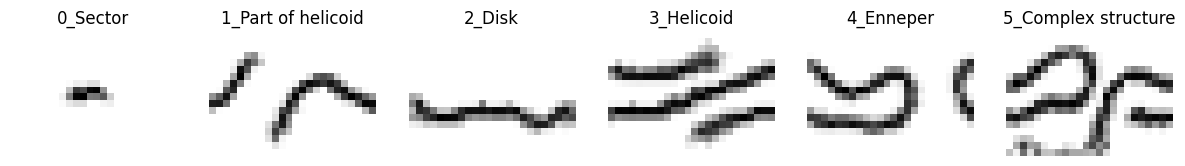

In [16]:
pdf.show_one_example_per_label(test_set)

Setting up Data Loaders with Batch Size and Workers

In [32]:
BATCH_SIZE = 18
NUM_WORKERS = 2

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)

## Init and train model

Model initialization, training setup, and metrics plotting

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNN_Net            | 216 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | valid_acc | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | criterion | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
216 K     Trainable params
0         Non-trainable params
216 K     Total params
0.865     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval m

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


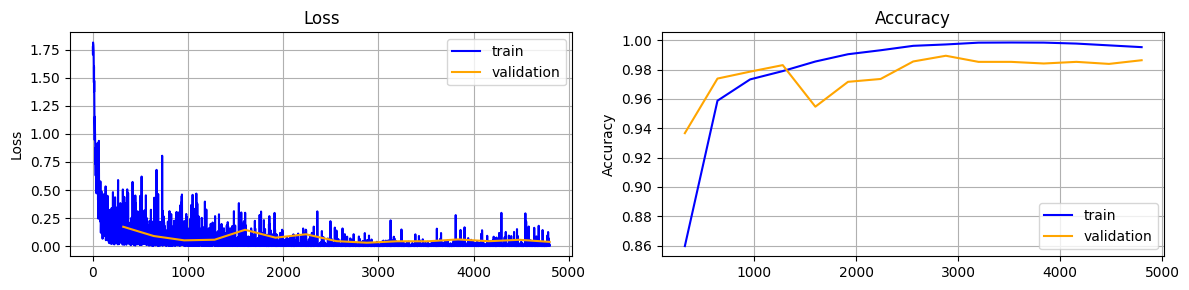

In [33]:
model = mmf.CNN_Net(image_height=18, image_width=24).to(device)
lit_model = mtf.Lit(model, optimizer_type = 'Adam')
os.path.join(notebook_path, git_path,'lightning_logs')
log_dir = os.path.join(notebook_path, git_path,'lightning_logs')
os.makedirs(log_dir, exist_ok=True)
trainer = L.Trainer(max_epochs=15, log_every_n_steps=5)
trainer.fit(model=lit_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
mtf.plot_training_metrics(trainer)

Loading Best Model and Testing
The path to the best model is stored in the folder ./lightning_logs/version_0/checkpoints

<ipython-input-34-d24464366c59>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INF

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │     0.987500011920929     │
│         test_loss         │    0.03683044761419296    │
└───────────────────────────┴───────────────────────────┘

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


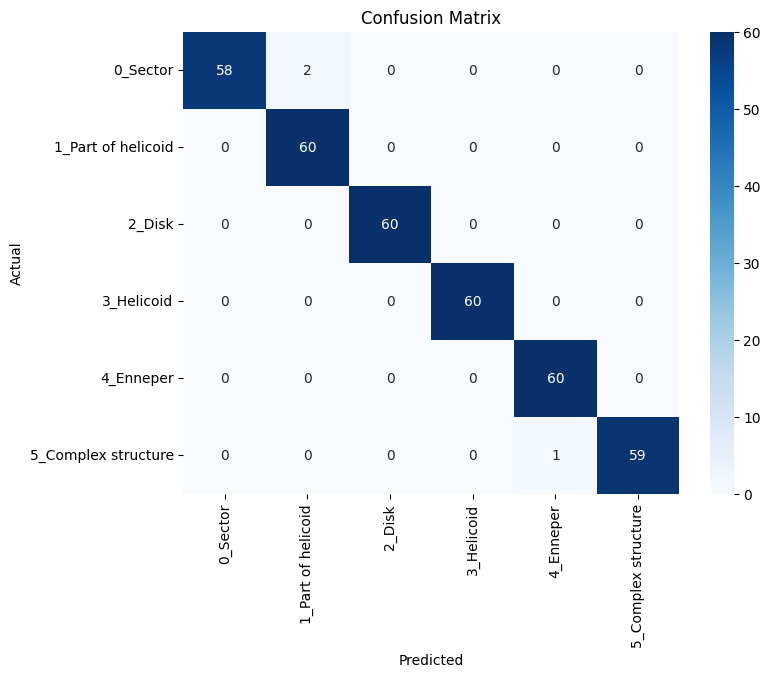

In [34]:
model_best = mmf.CNN_Net(image_height=18, image_width=24).to(device)

# Check if the file name is correct№
checkpoint_path = os.path.join(log_dir,'version_0','checkpoints','epoch=14-step=24000.ckpt')

checkpoint = torch.load(checkpoint_path)

new_state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
model_best.load_state_dict(new_state_dict)
lit_model_best = mtf.Lit(model_best)
trainer.test(model=lit_model_best, dataloaders=test_loader)

mtf.plot_confusion_matrix(model_best, test_loader, test_set, n_shift=10)

Save best model

In [31]:
torch.save(model_best.state_dict(), 'model_phi_theta.pth')